In [1]:
import os
import numpy as np
import pandas as pd
from collections import deque

!pip install music21
!pip install pygame

from music21 import converter, instrument, note, chord, bar, midi, stream, meter

from keras.models import Model, Sequential
from keras.layers import *
from keras.models import load_model
import keras.backend as K
import keras.callbacks
from keras.utils import Sequence
from keras.utils import to_categorical
from keras.preprocessing.sequence import TimeseriesGenerator

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.
Using TensorFlow backend.


In [2]:
# grab / parse data

In [33]:
midi_directory = "midi/Chopin"
# specify the number of track in each song (should be the same, in same order, for each song)
tracks = (0,)
instru = instrument.Piano()

notes = [[] for track in tracks]
durations = [[] for track in tracks]
for i, file in enumerate(os.listdir(midi_directory)):
    midi_part = converter.parse(os.path.join(midi_directory, file))
    # Parse the midi file by the notes/chords it contains
    for track, _ in enumerate(tracks):
        notes_to_parse = midi_part[tracks[track]].flat.notesAndRests
        #notes_to_parse = notes_to_parse.makeMeasures()
        #for meas in notes_to_parse.measures(0, None):
            #if isinstance(meas, stream.Measure):
                #meas = meas.chordify()
        for elem in notes_to_parse:
            if isinstance(elem, note.Note):
                notes[track].append([str(elem.pitch)])
                durations[track].append(elem.quarterLength)
            elif isinstance(elem, chord.Chord):
                notes[track].append([str(n.nameWithOctave) for n in elem.pitches])
                durations[track].append(elem.quarterLength)
            elif isinstance(elem, note.Rest):
                notes[track].append([elem.name])
                durations[track].append(elem.quarterLength)
    print("Song %s Loaded" % file)
print("DONE LOADING SONGS") 
# Get all notes
np_notes = [np.array(notes[track]) for track in tracks]
np_notes = [np_notes[track].flatten() for track in tracks]
notes_vocab = [[] for track in tracks]
for track, _ in enumerate(tracks):
    for item in np_notes[track]:
        if len(item) > 1 and item != "rest":
            notes_vocab[track].append(",".join([note for note in item]))
        else:
            notes_vocab[track].append(item[0])
    notes_vocab[track] = sorted(set(notes_vocab[track]))
# Get all durations
durations_vocab = [[] for track in tracks]
for track, _ in enumerate(tracks):
    durations_vocab[track] = sorted(set(durations[track]))

for track, _ in enumerate(tracks):
    print("%s Notes, notes_Vocab : %s ; durations_Vocab : %s" % (len(notes[track]), len(notes_vocab[track]), len(durations_vocab[track])))
print(notes_vocab, notes)
print(durations_vocab, durations)

Song chpn_op10_e01_format0.mid Loaded
Song chpn_op10_e05_format0.mid Loaded
Song chpn_op10_e12_format0.mid Loaded
Song chpn_op7_1_format0.mid Loaded
Song chpn_op7_2_format0.mid Loaded
Song chp_op18_format0.mid Loaded
Song chp_op31_format0.mid Loaded
DONE LOADING SONGS
11645 Notes, notes_Vocab : 1065 ; durations_Vocab : 61
[['A1', 'A1,A2', 'A2', 'A2,A1', 'A2,A3', 'A2,C5,C6', 'A3', 'A3,A2', 'A3,A2,C#3', 'A3,A4', 'A3,A4,A2', 'A3,C#3', 'A3,C#4,F#4', 'A3,C4,F#4', 'A3,F4,A4,C#2,A2', 'A3,F4,A4,C2,A2', 'A3,F4,F2,C3,F3', 'A4', 'A4,A2', 'A4,A3', 'A4,A5,F#3,A3', 'A4,C#4,F3', 'A4,C#5,C#4', 'A4,C5,A5,F5,F2,C3,F3', 'A4,C5,E-5,A5', 'A4,E-4,C4,F3', 'A4,E-5,A5', 'A4,F#4,A3', 'A4,F#4,E-4,C4', 'A4,F2,C5,C3,F5,A3', 'A4,F2,C5,C3,F5,F3', 'A4,F3,C4,E-4', 'A4,F5,F4,C4,F3', 'A5', 'A5,A4', 'A5,A4,C#4,C#3', 'A5,A4,C#5,F#5', 'A5,A6,F#4,C5', 'A5,C4', 'A5,C5,E-5,A4', 'A5,D2,D3', 'A5,D3,D4', 'A5,E-5,E-6', 'A5,E-5,F5,A4', 'A5,F#2,F#3', 'A5,F#3', 'A5,F#4,C4,B-3', 'A5,F4', 'A6', 'A6,A5,F#4,C5', 'A6,C6,A5', 'B-1', 'B-1,

In [34]:
# turn notes to integers:

In [35]:
cat_notes = [[] for track in tracks]
cat_durations = [[] for track in tracks]
for track, _ in enumerate(tracks):
    for elem in notes[track]:
        int_note = notes_vocab[track].index(",".join(elem))
        cat = np.zeros((len(notes_vocab[track])))
        cat[int_note] = 1
        cat_notes[track].append(cat)
    for elem in durations[track]:
        int_duration = durations_vocab[track].index(elem)
        cat = np.zeros((len(durations_vocab[track])))
        cat[int_duration] = 1
        cat_durations[track].append(cat)
# merge
x = [cat_notes, cat_durations]

In [36]:
# Build generator

In [37]:
seq_len = 32
batch_size = 32
#split = int(0.8 * len(x))

class dataGenerator(Sequence):
    def __init__(self, x, batch_size):
        self.batch_size = batch_size
        self.x = x
    def __len__(self):
        return len(self.x[0][0]) // self.batch_size - 1
    def __getitem__(self, idx):
        X_note = [[] for track in tracks]
        X_duration = [[] for track in tracks]
        Y_note = [[] for track in tracks]
        Y_duration = [[] for track in tracks]
        res = [[], []]
        for track, _ in enumerate(tracks):
            for i in range(self.batch_size):
                X_note[track].append(self.x[0][track][idx+i : idx+i + seq_len])
                X_duration[track].append(self.x[1][track][idx+i : idx+i + seq_len])
                Y_note[track].append(self.x[0][track][idx+i + seq_len])
                Y_duration[track].append(self.x[1][track][idx+i + seq_len])
            X_note[track] = np.array(X_note[track])
            X_duration[track] = np.array(X_duration[track])
            Y_note[track] = np.array(Y_note[track])
            Y_duration[track] = np.array(Y_duration[track])
            res[0].append(X_note[track])
            res[0].append(X_duration[track])
            res[1].append(Y_note[track])
            res[1].append(Y_duration[track])
        return res
data_gen = dataGenerator(x, batch_size)

In [38]:
data_gen[0][0][0][0].shape

(32, 1065)

In [39]:
# Build Model

In [40]:
K.clear_session()

inputs_list = []
tracks_list = []
outputs_list = []

for track, _ in enumerate(tracks):
    in_note = Input(shape=(seq_len, len(notes_vocab[track])))
    inputs_list.append(in_note)
    x1 = Bidirectional(LSTM(32))(in_note)
    tracks_list.append(x1)
    in_duration = Input(shape=(seq_len, len(durations_vocab[track])))
    inputs_list.append(in_duration)
    x2 = Bidirectional(LSTM(32))(in_duration)
    tracks_list.append(x2)

concat = Concatenate()(tracks_list)
shared = Dense(64, activation='relu')(concat)

for track, _ in enumerate(tracks):
    out_note = Dense(len(notes_vocab[track]), activation='softmax')(shared)
    outputs_list.append(out_note)
    out_duration = Dense(len(durations_vocab[track]), activation='softmax')(shared)
    outputs_list.append(out_duration)

model = Model(inputs=inputs_list, 
              outputs=outputs_list)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 1065)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 32, 61)       0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 64)           281088      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 64)           24064       input_2[0][0]                    
__________________________________________________________________________________________________
concatenat

In [41]:
#save best model if model improved
model_name = "Chopin.h5"
best_checkpoint = keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [46]:
h = model.fit_generator(data_gen, epochs = 10, callbacks=[best_checkpoint])

Epoch 1/10
362/362 [==============================] - 24s 66ms/step - loss: 0.1574 - dense_2_loss: 0.1508 - dense_3_loss: 0.0066 - dense_2_acc: 0.9740 - dense_3_acc: 0.9987
Epoch 2/10
362/362 [==============================] - 25s 69ms/step - loss: 0.0610 - dense_2_loss: 0.0588 - dense_3_loss: 0.0022 - dense_2_acc: 0.9967 - dense_3_acc: 0.9998
Epoch 3/10
362/362 [==============================] - 25s 69ms/step - loss: 0.0585 - dense_2_loss: 0.0552 - dense_3_loss: 0.0033 - dense_2_acc: 0.9937 - dense_3_acc: 0.9996
Epoch 4/10
362/362 [==============================] - 24s 67ms/step - loss: 0.0311 - dense_2_loss: 0.0296 - dense_3_loss: 0.0015 - dense_2_acc: 0.9979 - dense_3_acc: 0.9999
Epoch 5/10
362/362 [==============================] - 24s 67ms/step - loss: 0.0340 - dense_2_loss: 0.0324 - dense_3_loss: 0.0015 - dense_2_acc: 0.9970 - dense_3_acc: 0.9999
Epoch 6/10
362/362 [==============================] - 24s 67ms/step - loss: 0.0822 - dense_2_loss: 0.0763 - dense_3_loss: 0.0059 - dens

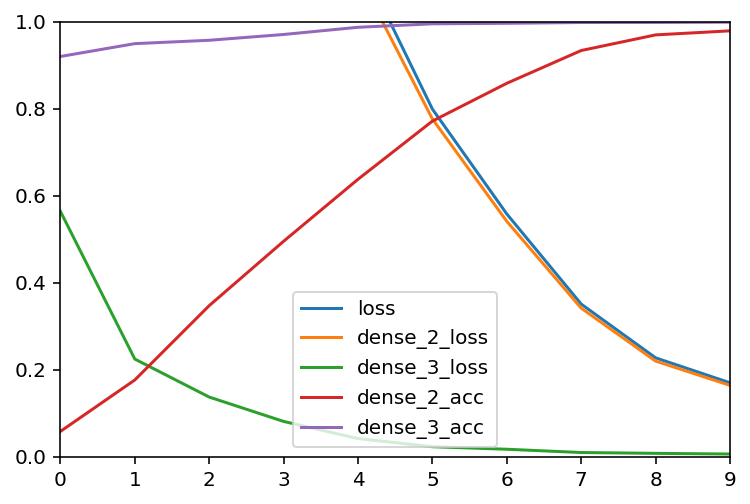

In [43]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

In [44]:
# Load / save

In [47]:
model_name = "Chopin.h5"
model.save(os.path.join("weight_save", model_name))
#model = load_model(os.path.join("weight_save", model_name))

In [48]:
# Test

In [55]:
# Build seed
idx = 42
x_test, _ = data_gen[idx]
x_test = [x_test[i][0] for i in range(len(x_test))]
x_test_stream = [stream.Stream() for track in tracks]

for track, _ in enumerate(tracks):
    for i in range(len(x_test[0])):
        str_note = notes_vocab[track][np.argmax(x_test[2*track][i])]
        duration = durations_vocab[track][np.argmax(x_test[2*track+1][i])]
        if len(str_note.split(",")) > 1:
            _chord = chord.Chord(str_note.split(","))
            _chord.quarterLength = duration
            x_test_stream[track].append(_chord)
        else:
            if str_note != "rest":
                _note = note.Note(str_note)
                _note.quarterLength = duration
                x_test_stream[track].append(_note)
            else:
                _rest = note.Rest()
                _rest.quarterLength = duration
                x_test_stream[track].append(_rest)
    x_test_stream[track].insert(0, instru)

In [56]:
# make seq_len predictions from seed
preds = [[] for track in tracks]
x = x_test

for _ in range(seq_len*2):
    pred = model.predict([np.array([x[i]]) for i in range(len(x))])
    _note = [pred[i] for i in range(0, len(pred), 2)]
    _duration = [pred[i] for i in range(1, len(pred), 2)]
    for track, _ in enumerate(tracks):
        cat_note = np.zeros((len(notes_vocab[track])))
        _note[track] = np.argmax(_note[track])
        cat_note[_note[track]] = 1
        cat_duration = np.zeros((len(durations_vocab[track])))
        _duration[track] = np.argmax(_duration[track])
        cat_duration[_duration[track]] = 1
        x[2*track] = x[2*track][1:]
        x[2*track] = list(x[2*track]) + [cat_note]
        x[2*track+1] = x[2*track+1][1:]
        x[2*track+1] = list(x[2*track+1]) + [cat_duration]
        preds[track].append((cat_note, cat_duration))

In [57]:
# Build predicted stream
y_test_stream = [stream.Stream() for track in tracks]

for track, _ in enumerate(tracks):
    for i in range(len(preds[track])):
        str_note = notes_vocab[track][np.argmax(preds[track][i][0])]
        duration = durations_vocab[track][np.argmax(preds[track][i][1])]
        if len(str_note.split(",")) > 1:
            _chord = chord.Chord(str_note.split(","))
            _chord.quarterLength = duration
            y_test_stream[track].append(_chord)
        else:
            if str_note != "rest":
                _note = note.Note(str_note)
                _note.quarterLength = duration
                y_test_stream[track].append(_note)
            else:
                _rest = note.Rest()
                _rest.quarterLength = duration
                y_test_stream[track].append(_rest)
    y_test_stream[track].insert(0, instru)

In [58]:
# play seed
x_full_score = stream.Score()
for track, _ in enumerate(tracks):
    p = stream.Part()
    p.append(x_test_stream[track])
    x_full_score.insert(0, p)
x_full_score.makeMeasures()#.show('musicxml')
x_full_score.chordify()
x_full_score.write("midi", "x_test.mid")
sp = midi.realtime.StreamPlayer(x_full_score)
sp.play()

In [59]:
# play generated music
y_full_score = stream.Score()
for track, _ in enumerate(tracks):
    p = stream.Part()
    p.append(y_test_stream[track])
    y_full_score.insert(0, p)
y_full_score.makeMeasures()#.show('musicxml')
y_full_score.chordify()
y_full_score.write("midi", "y_test.mid")
sp = midi.realtime.StreamPlayer(y_full_score)
sp.play()